## Financial Time Series and Their Characteristics

Both financial theory and its empirical time series contain an element of uncertainty. For example, there are various definitions of asset volatility, and for a stock return series, __the volatility is not directly observable__. As a result of the added uncertainty, statistical theory and methods play an important role in financial time series analysis.

In this lecture, we will study:

* asset returns
* descriptive statistics of returns
* distributional properties of returns

In [141]:
import numpy as np
import scipy
import math
from pandas_datareader import data
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
from tabulate import tabulate
%matplotlib inline

### The Time Value of Money

Future value, present value and simple interest:

$$FV_n = V(1+R) \times \cdots \times (1+R) = V \cdot (1+R)^n$$

$$PV = \frac{FV_n}{(1+R)^n}$$

$$n = \frac{\ln(FV_n /V)}{\ln(1+R)} $$

It is very easy to calculate how long it will take to double the value.

In [16]:
r = [r/100 for r in range(1, 11)]
year = [math.log(2)/math.log(1+i) for i in r]
appro_year = [0.7/i for i in r]  # rule of 70
print(tabulate(zip(r, year, appro_year), headers=['R', 'Years', "Approximate Years"]))

   R     Years    Approximate Years
----  --------  -------------------
0.01  69.6607              70
0.02  35.0028              35
0.03  23.4498              23.3333
0.04  17.673               17.5
0.05  14.2067              14
0.06  11.8957              11.6667
0.07  10.2448              10
0.08   9.00647              8.75
0.09   8.04323              7.77778
0.1    7.27254              7


When the return is around $0.1$ or around $10\%$, it takes around 7 years to double your assets.

If interest is paid $m$ times per year then the future value after $n$ years is

$$FV_n^m = V \cdot ( 1 + \frac{R}{m})^{m\cdot n}$$

For the continuously compouneded, we could have:

$$FV_n^c = \lim_{m \to \infty} V \cdot (1 + \frac{R}{m})^{m\cdot n} = V \cdot e ^{R \cdot n}$$

In [12]:
fre = [1, 4, 52, 365, 1_000]  # compounding frequency
r = 0.1  # interest is 10% at the end of year
v0 = 100  # initial value
fv = [v0*(1 + r/f)**(f*1) for f in fre]
print('The final value of 100 at the end of one year (n=1)')
print(tabulate(zip(fre, fv), headers=['Frequency', 'Value']))

The final value of 100 at the end of one year (n=1)
  Frequency    Value
-----------  -------
          1  110
          4  110.381
         52  110.506
        365  110.516
       1000  110.517


### Effective annual rate

We now consider the relationship between simple interest rates, periodic rates, effective annual rates and continuously compounded rates. Suppose an investment pays a periodic interest rate of $2\%$ each quater. This gives rise to a simple annual rate of $8\%$ ($2\% \times 4$ quarters). At the end of the year, $\$ 1000$ invested accrues to 

$$1000 \cdot ( 1 + \frac{0.08}{4})^{4 \cdot 1} = 1082.4$$

The _effective annual rate_, $R_A$, on the investment is determined by the relationship 

$$1000 \cdot (1 + R_{A}) = 1082.4$$

Solving for $R_A$ gives

$$R_A = \frac{1082.4}{1000} - 1 = 0.0824$$

Here, __the effective annual rate is the simple interest rate with annual compounding__ that gives the same future value that occurs with simple interest compounded four times per year. The formula is

$$R_A = (1 + \frac{R}{m})^m -1 $$

The relationship between the effective annual rate and the simple rate that is compounded continuously is

$$(1+R_A) = e^R$$

Hence, 

$$R_A = e^R - 1; \ \ \ \ \ \ R = \ln(1 + R_A)$$

### Asset Return Calculations

In this section, we review asset return calculations given initial and future prices associated with an investment. We first cover simple return calcualtions, which are typically reported in practice but are often not convinent for statistical modeling purposes. We then describe continuously compounded return calculations, which are more covinent for statistical modeling purposes.

In [2]:
# get the dataset
ticker = 'AAPL'
start_date = '2010-01-01'
end_date = '2020-12-31'

appl_data = data.DataReader(ticker, 'yahoo', start_date, end_date)
appl_data = appl_data.asfreq('B')  # frequency based on business day, this is very improtant
clean_data = appl_data.dropna().copy()

In [108]:
clean_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-12-31,7.619643,7.520000,7.611786,7.526071,352410800.0,6.482683
2010-01-04,7.660714,7.585000,7.622500,7.643214,493729600.0,6.583586
2010-01-05,7.699643,7.616071,7.664286,7.656429,601904800.0,6.594968
2010-01-06,7.686786,7.526786,7.656429,7.534643,552160000.0,6.490066
2010-01-07,7.571429,7.466071,7.562500,7.520714,477131200.0,6.478067
...,...,...,...,...,...,...
2020-12-24,133.460007,131.100006,131.320007,131.970001,54930100.0,131.773087
2020-12-28,137.339996,133.509995,133.990005,136.690002,124486200.0,136.486053
2020-12-29,138.789993,134.339996,138.050003,134.869995,121047300.0,134.668762


<AxesSubplot:xlabel='Date'>

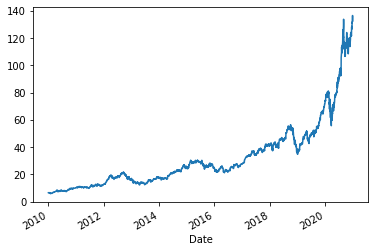

In [84]:
clean_data['Adj Close'].plot()

In [113]:
## prepare the dataset
clean_data['day'] = clean_data.index.day
clean_data['month'] = clean_data.index.month
clean_data['year'] = clean_data.index.year
clean_data['week_day'] = clean_data.index.dayofweek
clean_data['week_day_name'] = clean_data.index.strftime('%A')

In [133]:
clean_data.tail()

,High,Low,Open,Close,Volume,Adj Close,day,month,year,week_day,week_day_name
Date,,,,,,,,,,,
2020-12-24,133.460007,131.100006,131.320007,131.970001,54930100.0,131.773087,24,12,2020,3,Thursday
2020-12-28,137.339996,133.509995,133.990005,136.690002,124486200.0,136.486053,28,12,2020,0,Monday
2020-12-29,138.789993,134.339996,138.050003,134.869995,121047300.0,134.668762,29,12,2020,1,Tuesday
2020-12-30,135.990005,133.399994,135.580002,133.720001,96452100.0,133.520477,30,12,2020,2,Wednesday
2020-12-31,134.740005,131.720001,134.080002,132.690002,99116600.0,132.492020,31,12,2020,3,Thursday


In [160]:
clean_data.isnull().values.any()

False

In [134]:
clean_data.to_csv("apple_stock.csv")

In [124]:
def total_return(prices):
    """Retuns the return between the first and last value of the DataFrame.
    Parameters
    ----------
    prices : pandas.Series or pandas.DataFrame
    Returns
    -------
    total_return : float or pandas.Series
        Depending on the input passed returns a float or a pandas.Series.
    """
    return prices.iloc[-1] / prices.iloc[0] - 1

In [153]:
group_data = clean_data.groupby(by=['year', 'month'])['Adj Close'].apply(total_return)
group_data

year  month
2009  12       0.000000
2010  1       -0.102565
      2        0.050788
      3        0.124455
      4        0.106454
                 ...   
2020  8        0.186668
      9       -0.136906
      10      -0.067900
      11       0.096400
      12       0.081242
Name: Adj Close, Length: 133, dtype: float64

<AxesSubplot:xlabel='year,month'>

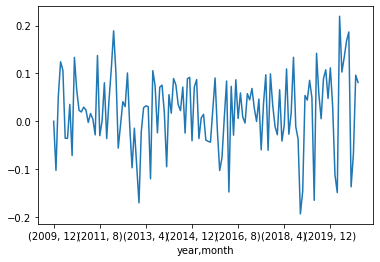

In [154]:
group_data.plot()

In [150]:
np.log(1 + group_data)  # monthly cc returns

year  month
2009  12       0.000000
2010  1       -0.108215
      2        0.049540
      3        0.117299
      4        0.101161
                 ...   
2020  8        0.171150
      9       -0.147231
      10      -0.070315
      11       0.092032
      12       0.078110
Name: Adj Close, Length: 133, dtype: float64

In [158]:
clean_data['Adj Close'].resample('M').ffill().pct_change()

Date
2009-12-31         NaN
2010-01-31   -0.088597
2010-02-28    0.065396
2010-03-31    0.148470
2010-04-30    0.111022
                ...   
2020-08-31    0.216569
2020-09-30   -0.102526
2020-10-31   -0.060012
2020-11-30    0.095493
2020-12-31    0.114574
Freq: M, Name: Adj Close, Length: 133, dtype: float64

In [164]:
np.log(clean_data['Adj Close'].resample('M').ffill().pct_change()+1)

Date
2009-12-31         NaN
2010-01-31   -0.092770
2010-02-28    0.063347
2010-03-31    0.138431
2010-04-30    0.105280
                ...   
2020-08-31    0.196035
2020-09-30   -0.108172
2020-10-31   -0.061888
2020-11-30    0.091205
2020-12-31    0.108472
Freq: M, Name: Adj Close, Length: 133, dtype: float64

`resample` method use the price of last of day of previous month to calculate the month return.

<AxesSubplot:xlabel='Date'>

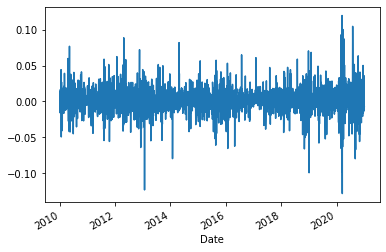

In [162]:
# daily return
clean_data['Adj Close'].pct_change().plot()

### Time Series Concepts

A stochastic process $\{ Y_t \}_{t = - \infty}^\infty$ is _strict stationary_ if, for any given finite integer $r$ and for any set of subscripts $t_1, t_2, \cdots, t_r$ the joint distribution of $(Y_{t_1}, Y_{t_2}, \cdots, Y_{t_r})$ depends only on $t_1 - t, t_2 - t, \cdots, t_r - t$ but not on $t$. 

A stochastic process $\{Y_t\}_{t=1}^\infty$ is _convariance stationary_ if 

1. $E[Y_T] = \mu$ does not depend on $t$
2. $var(Y_t) = \sigma^2$ does not depend on $t$
3. $cov(Y_t, Y_{t-j}) = \gamma_j$ exsits, is finite, and depends only on $j$ but not on $t$ for $j = 0, 1, 2, \cdots$

The term $\gamma_j$ is called the $j^{th}$ order _autocovariance_. The $j^{th}$ order autocorrelation is defined as

$$\rho_j = \frac{cov(Y_t, Y_{t-j})}{\sqrt{var(Y_t)var(Y_{t-j})}} = \frac{\gamma_j}{\sigma^2}$$

The autocovariances measure the direction of linear dependence between $Y_t$ and $Y_{t-j}$. The autocorrelations measure both the direction and strength of linear dependence between $Y_t$ and $Y_{t-j}$. 

The autocovariances and autocorrelations are measures of the linear termporal dependence in a covariance stationary stochastic process. A graphic summary of this temporal dependence is given by the plot of $\rho_j$ against $j$, and is called the _autocorrelation function_ (ACF).

One special autocovariance stationary process is the _Gaussian White Noise_, which is defined as follows: Let $Y_t \sim iid \ N(0, \sigma^2)$, Then $\{Y_t\}_{t = - \infty}^\infty$ is called a _Gaussian white noise_ process and is denoted $Y_t \sim GWN(0, \sigma^2)$. Notice that:

* $E[Y_t] = 0$ independent of $t$
* $V(Y_t) = \sigma^2$ independent of $t$
* $cov(Y_t, Y_{t-j}) = 0 $ for ($j > 0$) independent of $t$ for all $j$.

In the electrical engineering literature, white
noise represents the __absence of any signal__.

> If a time series is white noise, it is a sequence of random numbers and cannot be predicted. If the series of forecast errors are not white noise, it suggests improvements could be made to the predictive model.

In [29]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from random import gauss
from random import seed
from pandas import Series
from pandas.plotting import autocorrelation_plot
seed(156)  # see the seed

In [3]:
series = [gauss(0.0, 1.0) for i in range(1000)]
series = Series(series)
series.describe()

count    1000.000000
mean        0.042187
std         0.979419
min        -2.715893
25%        -0.605595
50%         0.057427
75%         0.704655
max         3.108592
dtype: float64

<AxesSubplot:>

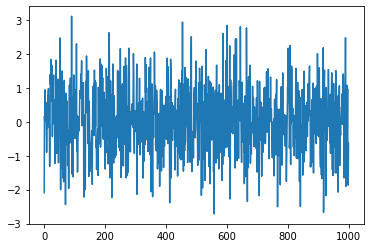

In [4]:
series.plot()

<AxesSubplot:>

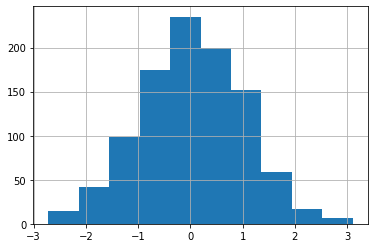

In [5]:
series.hist()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

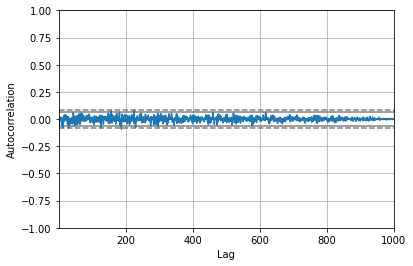

In [6]:
autocorrelation_plot(series)

#### Non-Stationary Process

In a covariance stationary stochastic process it is assumed that the means,
variances and autocovariances are independent of time. In a non-stationary
process, one or more of these assumptions is not true.

__Deterministically trending process__: $Y_t = \beta_0 + \beta_1 t + \epsilon_t, \ \ \epsilon_t \sim WN(0, \sigma_\epsilon^2)$, it is nonstationary because the mean of $Y_t$ depends on $t$:

$$E[Y_t] = \beta_0 + \beta_1 t$$

<AxesSubplot:>

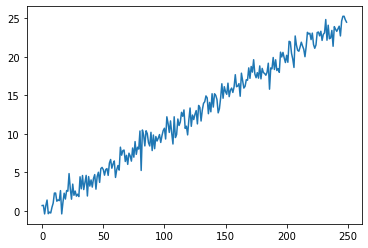

In [25]:
dtrend = [0.1 * i + gauss(0.0, 1.0) for i in range(250)]
dtrend = Series(dtrend)
dtrend.plot()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

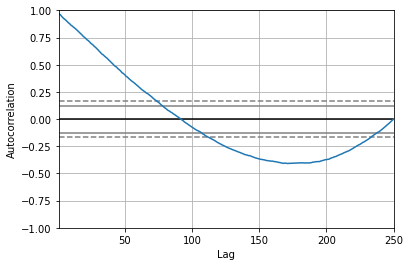

In [26]:
autocorrelation_plot(dtrend)

__Random walk__: $Y_t = Y_{t-1} + \epsilon_t, \ \epsilon_t \sim iid(0, \sigma_{\epsilon}^2)$ with $Y_0$ is fixed. By recursive substituion starting $t = 1$, we have:

$$Y_t = Y_0 + \sum_{j=1}^t \epsilon_t$$

Now, $E[Y_t] = Y_0$ which is independent of $t$. However, 

$$var(Y_t) = var(\sum_{j=1}^t \epsilon_j) = \sigma_{\epsilon}^2 \times t$$

<AxesSubplot:>

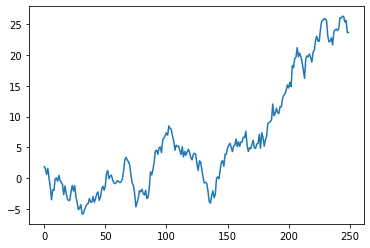

In [21]:
rwalk = [gauss(0.0, 1.0) for i in range(250)]
rwalk = Series(np.cumsum(rwalk))
rwalk.plot()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

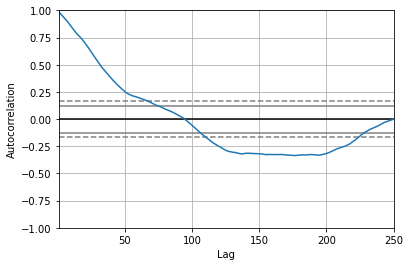

In [27]:
autocorrelation_plot(rwalk)

<AxesSubplot:>

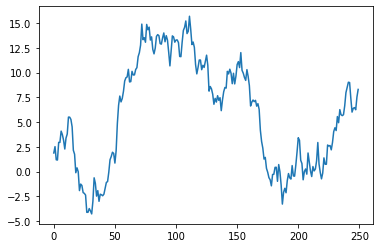

In [22]:
rwalk = [gauss(0.0, 1.0) for i in range(250)]
rwalk = Series(np.cumsum(rwalk))
rwalk.plot()

<AxesSubplot:>

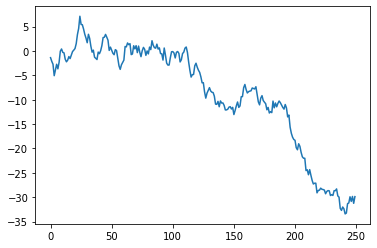

In [24]:
rwalk = [gauss(0.0, 1.0) for i in range(250)]
rwalk = Series(np.cumsum(rwalk))
rwalk.plot()

### Ergodicity

In a strictly stationary or covariance stationary stochastic process no assumption is made about the strength of dependence between random variables in
the sequence. For example, in a covariance stationary stochastic process
it is possible $\rho_1 = \rho_{100} = 0.5$. However, in many contexts it is reasonable to assume that the strength of
dependence between random variables in a stochastic process diminishes the
farther apart they become. That is $\rho_1 > \rho_2> \cdots$ and that eventually $\rho_j = 0$ for $j$ large enough.

Intuitively, a stochastic process $\{Y_t\}_{t=-\infty}^\infty$ is _ergodic_ if any two collections of random variables partitioned far apart in the sequence are essentially independent. 

The different flavors of white noise processes are not very interesting because they do not allow any linear dependence between the observations in
the series. 

But some models allow us to that, such as MA(1) and AR(1) process.

__MA(1)__: $Y_t = \mu + \epsilon_t + \theta \epsilon_{t-1}, \ \ -1 < \theta < 1$

__AR(1)__: $Y_t - \mu =\phi(Y_{t-1} - \mu) + \varepsilon_t, \ \ -1 < \phi < 1$

Properties of MA(1):

\begin{align}
E[Y_t] & = \mu \\
var(Y_t) & = \sigma_{\epsilon}^2(1 + \theta^2) \\
cov(Y_t, Y_{t-1}) & = \theta \sigma_{\epsilon}^2 
\end{align}

MA(1) is a _covariance stationary process_ as we can
show that the mean, variance and autocovariances are time invariant. Its behiavour is determined by $\epsilon$ and $\theta$.

Properties of AR(1):

\begin{align}
E[Y_t] & = \mu \\
var(Y_t) & = \sigma_{\varepsilon}^2(1 - \phi^2) \\
cov(Y_t, Y_{t-1}) & = \phi^j
\end{align}

Notice that the restriction $|\phi| < 1$ implies that

$$\lim_{j \to \infty} \rho_j = \phi^j = 0$$

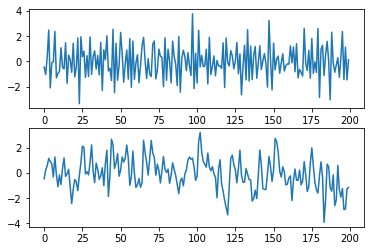

In [33]:
# plot1: ma parameter = -0.9
plt.subplot(2, 1, 1)
ar1 = np.array([1])
ma1 = np.array([1, -0.9])  # with zero lag coefficient 1
MA_object1 = sm.tsa.ArmaProcess(ar1, ma1)
simulated_data_1 = MA_object1.generate_sample(nsample=200)
plt.plot(simulated_data_1)
plt.subplot(2, 1, 2)
ar2 = np.array([1])
ma2 = np.array([1, 0.9])  # with zero lag coefficient 1
MA_object2 = sm.tsa.ArmaProcess(ar2, ma2)
simulated_data_2 = MA_object2.generate_sample(nsample=200)
plt.plot(simulated_data_2)

In [38]:
MA_object2.isinvertible

True

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

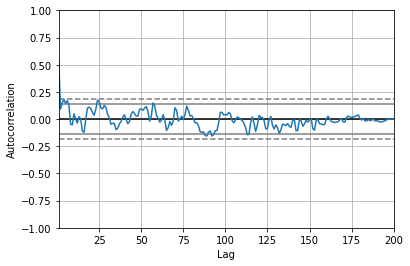

In [34]:
autocorrelation_plot(simulated_data_2)

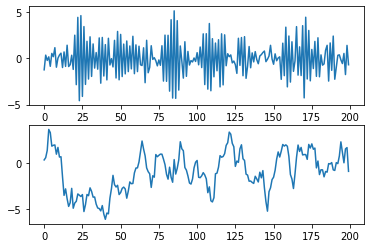

In [35]:
plt.subplot(2, 1, 1)
ar1 = np.array([1, 0.9])
ma1 = np.array([1])  # with zero lag coefficient 1
AR_object1 = sm.tsa.ArmaProcess(ar1, ma1)
simulated_data_ar1 = AR_object1.generate_sample(nsample=200)
plt.plot(simulated_data_ar1)
plt.subplot(2, 1, 2)
ar2 = np.array([1, -0.9])
ma2 = np.array([1])  # with zero lag coefficient 1
AR_object2 = sm.tsa.ArmaProcess(ar2, ma2)
simulated_data_ar2 = AR_object2.generate_sample(nsample=200)
plt.plot(simulated_data_ar2)

In [39]:
AR_object2.isinvertible

True

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

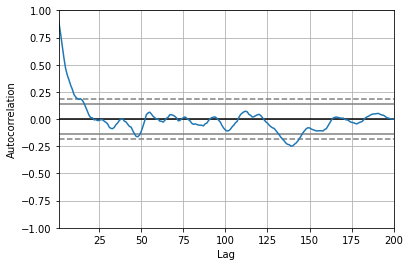

In [37]:
autocorrelation_plot(simulated_data_ar2)

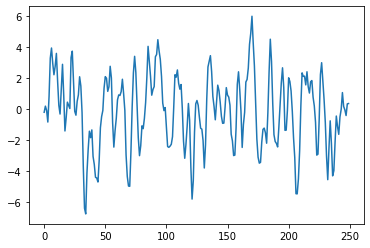

In [40]:
# ARMA(2, 2)
np.random.seed(12345)
arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
arma_process = sm.tsa.ArmaProcess(ar, ma)
arma_process.isstationary
y = arma_process.generate_sample(250)
plt.plot(y)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

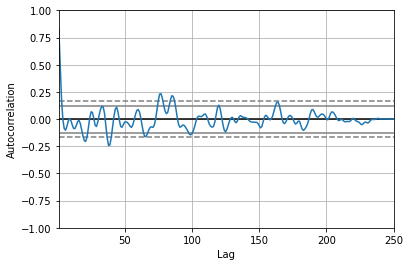

In [41]:
autocorrelation_plot(y)

### Descriptive Statistic for Financial Data

In this part, we use graphical and numerical descriptive statistics to study the distribution and dependence properties of daily and montly asset returns on a number of representative assets.

In [7]:
# get the dataset
ticker = 'msft'
start_date = '1998-01-01'
end_date = '2020-12-31'

msft_daily = data.DataReader(ticker, 'yahoo', start_date, end_date)
msft_daily_clean = msft_daily.dropna().copy()
msft_daily_clean

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1997-12-31,16.437500,16.125000,16.375000,16.156250,46147200.0,10.261655
1998-01-02,16.437500,16.187500,16.203125,16.390625,39748000.0,10.410520
1998-01-05,16.703125,15.984375,16.406250,16.296875,80377600.0,10.350970
1998-01-06,16.625000,16.156250,16.218750,16.390625,67834400.0,10.410520
1998-01-07,16.398438,15.937500,16.234375,16.195312,61492800.0,10.286464
...,...,...,...,...,...,...
2020-12-24,223.610001,221.199997,221.419998,222.750000,10550600.0,222.238144
2020-12-28,226.029999,223.020004,224.449997,224.960007,17933500.0,224.443069
2020-12-29,227.179993,223.580002,226.309998,224.149994,17403200.0,223.634918


<AxesSubplot:xlabel='Date'>

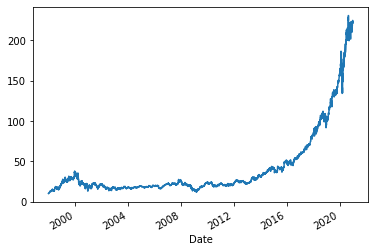

In [8]:
msft_daily_clean['Adj Close'].plot()

In [9]:
msft_monthly_clean = msft_daily_clean.resample('M').ffill()
msft_monthly_clean

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1997-12-31,16.437500,16.125000,16.375000,16.156250,46147200.0,10.261655
1998-01-31,18.750000,18.453125,18.578125,18.648438,50071200.0,11.844566
1998-02-28,21.500000,21.140625,21.390625,21.187500,47532400.0,13.457255
1998-03-31,22.437500,22.125000,22.156250,22.375000,38177200.0,14.211496
1998-04-30,22.906250,22.421875,22.875000,22.531250,54473600.0,14.310740
...,...,...,...,...,...,...
2020-08-31,228.699997,224.309998,227.000000,225.529999,28774200.0,224.424194
2020-09-30,211.979996,206.539993,207.729996,210.330002,33829100.0,209.298721
2020-10-31,204.289993,199.619995,203.500000,202.470001,36953700.0,201.477280


<AxesSubplot:xlabel='Date'>

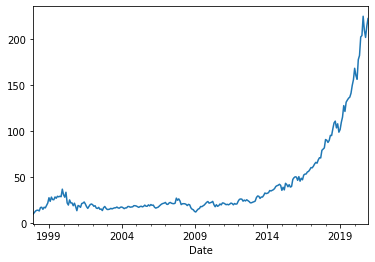

In [10]:
msft_monthly_clean['Adj Close'].plot()

In [85]:
tickers = ['msft', 'AAPL', '^gspc']
stocks_price = data.DataReader(tickers, 'yahoo', start_date, end_date)

In [86]:
price_daily = stocks_price.dropna().copy()
price_daily.isna().values.any()  # check is any na

False

In [87]:
price_daily

Attributes   Adj Close                                Close              \
Symbols           msft        AAPL        ^gspc        msft        AAPL   
Date                                                                      
1997-12-31   10.261655    0.100941   970.429993   16.156250    0.117188   
1998-01-02   10.410520    0.124974   975.039978   16.390625    0.145089   
1998-01-05   10.350970    0.122091   977.070007   16.296875    0.141741   
1998-01-06   10.410520    0.145644   966.580017   16.390625    0.169085   
1998-01-07   10.286464    0.134588   964.000000   16.195312    0.156250   
...                ...         ...          ...         ...         ...   
2020-12-24  222.238144  131.773087  3703.060059  222.750000  131.970001   
2020-12-28  224.443069  136.486053  3735.360107  224.960007  136.690002   
2020-12-29  223.634918  134.668762  3727.040039  224.149994  134.869995   
2020-12-30  221.170593  133.520477  3732.040039  221.679993  133.720001   
2020-12-31  221.908905  132.492020  3756.070068  222.419998  132.690002   

Attributes                     High                                  Low  \
Symbols           ^gspc        msft        AAPL        ^gspc        msft   
Date                                                                       
1997-12-31   970.429993   16.437500    0.121652   975.020020   16.125000   
1998-01-02   975.039978   16.437500    0.145089   975.039978   16.187500   
1998-01-05   977.070007   16.703125    0.147879   982.630005   15.984375   
1998-01-06   966.580017   16.625000    0.178571   977.070007   16.156250   
1998-01-07   964.000000   16.398438    0.169643   966.580017   15.937500   
...                 ...         ...         ...          ...         ...   
2020-12-24  3703.060059  223.610001  133.460007  3703.820068  221.199997   
2020-12-28  3735.360107  226.029999  137.339996  3740.510010  223.020004   
2020-12-29  3727.040039  227.179993  138.789993  3756.120117  223.580002   
2020-12-30  3732.040039  225.630005  135.990005  3744.629883  221.470001   
2020-12-31  3756.070068  223.000000  134.740005  3760.199951  219.679993   

Attributes                                 Open                           \
Symbols           AAPL        ^gspc        msft        AAPL        ^gspc   
Date                                                                       
1997-12-31    0.115513   967.409973   16.375000    0.117188   970.840027   
1998-01-02    0.120536   965.729980   16.203125    0.121652   970.429993   
1998-01-05    0.135603   969.000000   16.406250    0.147321   975.039978   
1998-01-06    0.131696   962.679993   16.218750    0.142299   977.070007   
1998-01-07    0.154576   952.669983   16.234375    0.167969   966.580017   
...                ...          ...         ...         ...          ...   
2020-12-24  131.100006  3689.320068  221.419998  131.320007  3694.030029   
2020-12-28  133.509995  3723.030029  224.449997  133.990005  3723.030029   
2020-12-29  134.339996  3723.310059  226.309998  138.050003  3750.010010   
2020-12-30  133.399994  3730.209961  225.229996  135.580002  3736.189941   
2020-12-31  131.720001  3726.879883  221.699997  134.080002  3733.270020   

Attributes      Volume                              
Symbols           msft          AAPL         ^gspc  
Date                                                
1997-12-31  46147200.0  4.063584e+08  4.672800e+08  
1998-01-02  39748000.0  7.181104e+08  3.667300e+08  
1998-01-05  80377600.0  6.518736e+08  6.280700e+08  
1998-01-06  67834400.0  1.812474e+09  6.183600e+08  
1998-01-07  61492800.0  1.041622e+09  6.673900e+08  
...                ...           ...           ...  
2020-12-24  10550600.0  5.493010e+07  1.885090e+09  
2020-12-28  17933500.0  1.244862e+08  3.527460e+09  
2020-12-29  17403200.0  1.210473e+08  3.387030e+09  
2020-12-30  20272300.0  9.645210e+07  3.145200e+09  
2020-12-31  20942100.0  9.911660e+07  3.172510e+09  

[5789 rows x 18 columns]

In [88]:
adjclose_price_daily = price_daily['Adj Close']
adjclose_price_daily.columns = ['msft', 'AAPL', 'SP500']
adjclose_price_daily

,msft,AAPL,SP500
Date,,,
1997-12-31,10.261655,0.100941,970.429993
1998-01-02,10.410520,0.124974,975.039978
1998-01-05,10.350970,0.122091,977.070007
1998-01-06,10.410520,0.145644,966.580017
1998-01-07,10.286464,0.134588,964.000000
...,...,...,...
2020-12-24,222.238144,131.773087,3703.060059
2020-12-28,224.443069,136.486053,3735.360107
2020-12-29,223.634918,134.668762,3727.040039


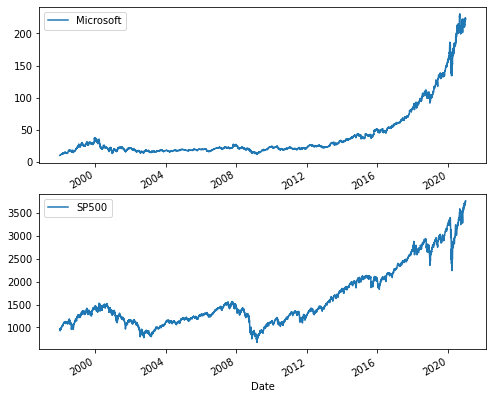

In [89]:
fig, axes = plt.subplots(2, 1, figsize=(8, 7))
adjclose_price_daily['msft'].plot(ax=axes[0], label='Microsoft')
axes[0].legend()
adjclose_price_daily['SP500'].plot(ax=axes[1], label='SP500')
axes[1].legend()

In [92]:
adjclose_price_monthly = adjclose_price_daily.resample("M").ffill()

In [97]:
# calculate daily returns
daily_return = adjclose_price_daily.pct_change().dropna()
daily_return

,msft,AAPL,SP500
Date,,,
1998-01-02,0.014507,0.238087,0.004750
1998-01-05,-0.005720,-0.023075,0.002082
1998-01-06,0.005753,0.192915,-0.010736
1998-01-07,-0.011916,-0.075909,-0.002669
1998-01-08,0.007236,0.039284,-0.008247
...,...,...,...
2020-12-24,0.007827,0.007712,0.003537
2020-12-28,0.009921,0.035766,0.008723
2020-12-29,-0.003601,-0.013315,-0.002227


<AxesSubplot:xlabel='Date'>

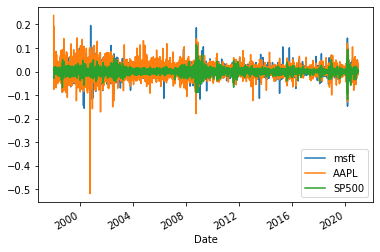

In [98]:
daily_return.plot()

<AxesSubplot:xlabel='Date'>

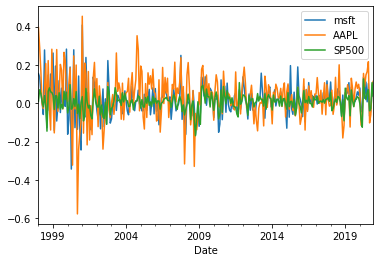

In [99]:
# calculate monthly return
monthly_return = adjclose_price_monthly.pct_change().dropna()
monthly_return.plot()

<AxesSubplot:xlabel='Date'>

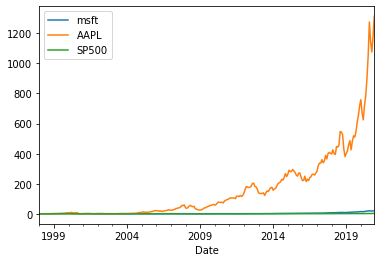

In [100]:
# calculate the equirty curve (cumulative returns) based on monthly returns
cumulative_monthly_return = np.cumprod(monthly_return.values + 1.0, axis=0)
cumulative_monthly_return = pd.DataFrame(cumulative_monthly_return, index=monthly_return.index, columns=['msft', 'AAPL', 'SP500'])
cumulative_monthly_return.plot()

<AxesSubplot:xlabel='Date'>

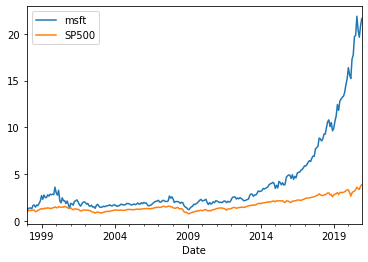

In [103]:
# calculate the equirty curve (cumulative returns) based on monthly returns
cumulative_monthly_return = np.cumprod(monthly_return.values + 1.0, axis=0)
cumulative_monthly_return = pd.DataFrame(cumulative_monthly_return[:, [0, 2]], index=monthly_return.index, columns=['msft', 'SP500'])
cumulative_monthly_return.plot()

array([[<AxesSubplot:title={'center':'msft'}>,
        <AxesSubplot:title={'center':'AAPL'}>],
       [<AxesSubplot:title={'center':'SP500'}>, <AxesSubplot:>]],
      dtype=object)

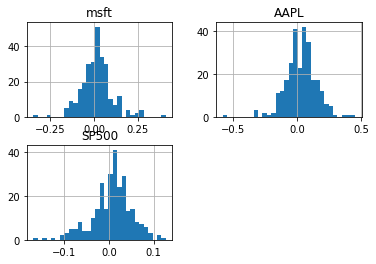

In [118]:
# historgram
monthly_return.hist(bins=30)

array([[<AxesSubplot:title={'center':'msft'}>,
        <AxesSubplot:title={'center':'AAPL'}>],
       [<AxesSubplot:title={'center':'SP500'}>, <AxesSubplot:>]],
      dtype=object)

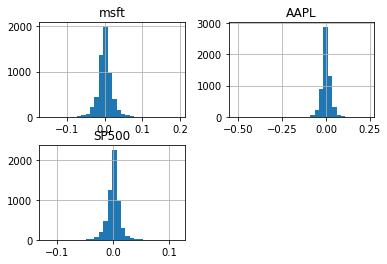

In [114]:
daily_return.hist(bins=30)

<AxesSubplot:>

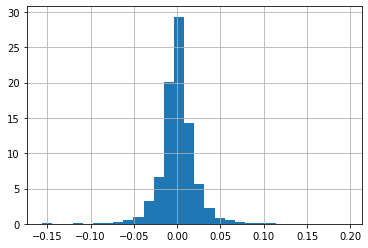

In [116]:
# focus on the miscroft
daily_return['msft'].hist(bins=30, density=True)

<AxesSubplot:ylabel='Density'>

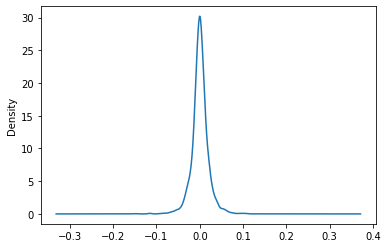

In [120]:
daily_return['msft'].plot.kde()

<AxesSubplot:ylabel='Density'>

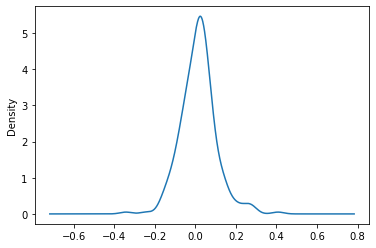

In [139]:
monthly_return['msft'].plot.kde()

### Empirical CDF and Value at Risk (VaR)

Recall, for $\alpha \in (0, 1)$ the $\alpha \times 100\%$ quantile of the distribution of a continuous random variable $X$ with CDF $F_X$ is the point $q_{\alpha}^X$ such that $F_X(q_{\alpha}^X) = \alpha$. Accordingly, the $\alpha \times 100 \%$ empirical quantile of a data sample $\{x_t\}_{t=1}^T$ is the data value $\hat{q}_\alpha$ such that $\alpha \times 100\%$ of the data are less than or equal to $\hat{q}_\alpha$. 

In [126]:
monthly_return_quantile = monthly_return.quantile([0.0, 0.25, 0.5, 0.75, 1.0])
monthly_return_quantile 

,msft,AAPL,SP500
0.00,-0.343529,-0.577436,-0.169425
0.25,-0.037669,-0.033050,-0.017885
0.50,0.017702,0.042856,0.010583
0.75,0.059242,0.103138,0.034079
1.00,0.407780,0.453783,0.126844


In [128]:
# value at risk
wealth = 100_000
monthly_return.quantile([0.01, 0.05]).values * wealth

array([[-16426.03088996, -31821.02672537, -11379.80592916],
       [-12397.46943982, -14578.52850436,  -7927.03588889]])

Based on the empirical distribution of the monthly returns, a $\$$100,000 monthly investment in Microsoft will lose $\$$12397 or more with 5% probability and
will lose \$16426 or more with 1\% probability. 

### QQ-plots

Often it is of interest to see if a given data sample could be viewed as a random sample from a specified probability distribution. One easy and effective way to do this is to compare the empirical quantiles of a data sample to those from a reference probability distribution. If the quantiles match up, then this provides strong evidence that the reference distribution is appropriate for describing the distribution of the observed data.

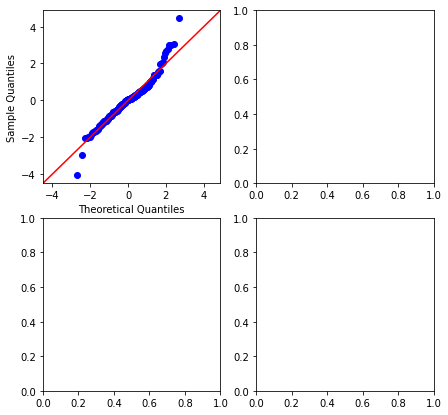

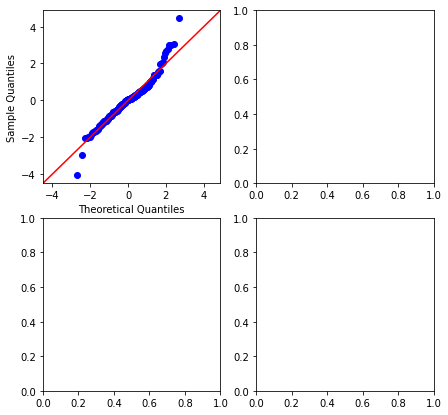

In [143]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))
sm.qqplot(monthly_return['msft'], fit=True, line='45', ax=axes[0, 0])

### References

Return Calculations by [Zivot](https://faculty.washington.edu/ezivot/econ424/returnCalculations.pdf)